In [ ]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.7 MB/s eta 0:00:00


In [345]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

from PIL import Image
import requests
from io import BytesIO
import numpy as np


# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

import torch.nn.functional as F
torch.manual_seed(1)
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

what I need to do
- explain the text embedder
- explain the VAE (encode an image)
- explain the UNet

# Stable Diffusion explainer!

Hello! welcome to my explainer for stable diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how Stable Diffusion works... BLAH.

At a high level, the way latent diffusion models work is by taking a completely random/noisy image, and then generating a visually coherent image from the noise by denoising it and then re-noising it a bunch of times, sequentially. Each time the image is denoised, the leftover signal (in this case, a noise-free image) will have a little more detailed information in it than last time. Once done enough times, you're left over with an image!

Text-to-image models simply build on this by having a few more layers (or algorithms) inside the denoising model, which "guide" the denoising model in leaving behind specific details in the structure once the noise is removed.

In a sense, you can think of latent diffusion models as marble sculptors morseo than illustrators - they have to take a noisy block of marble, and carve out their image, rather than take a blank canvas and paint it from scratch.




# the model

Two things first - one is that Latent Diffusion Models (LDMs) are a "cascade" of models, or essentially a set of several models, trained sequentially, that work together to create an output. Secondly, this exact cascade of models is only the architecture used in Stable Diffusion v1.4, where models like MidJourney, Dall-E and Imagen are going to differ somewhat. That being said, the vast majority of image generation models out there have a very similar cascade, organised in a very similar manner, with very similar logic. This cascade is also generally applied to things like text-to-audio and text-to-video - although those areas of research are still quite early days, and different approaches may be taken down the track.

For Latent Diffusion Models (or text-to-image models), the model cascade typically involves the following:

- text embedder: this is a text model which converts the input sentence into a vector embedding. This allows a computer to perform arithmetic operations on the sentence.

- Variational Auto-Encoder (VAE): this is a deep-learning model which is specialised in compressing images into a much smaller "latent" space, and also uncompresses from that latent space back to a full size image, while preserving as much quality as possible. Think of this as a very very advanced version of JPEG compression and decompression. For inference (or when we run the model), we will only need the decoder, or decompressor, but more on that later.

- Denoising model: this is the core of the model - essentially, it takes the latent space, estimates the noise, and then denoises the image.

In the case of Stable diffusion v1.4, we have the following:

- Text-embedder: CliP-ViT-L/14 - this is an open-source text-embedder and image-embedder model which is used to search for images with captions in an embedded space. Essentially, if a sentence is semantically similar to an image (for example, "dog" and a picture of a dog), the vector embeddings that they both output from this model will be very close to each other, whereas if they are different (for example, "dog" and a picture of spaghetti), they will be very far apart. Technically, your text embedder doesn't have to be fine tuned for image searching (i.e. it could simply be BERT, MiniLM, etc embeddings), but by using CliP, it means that the text embeddings are fine tuned to be the most descriptive for downstream image tasks, and the vector distance from the output image can also be used as a loss metric.

- Variational Auto-Encoder: custom model, fine tuned from Stable-Diffusion v1.2. This model was fine-tuned on a 64x64x4 latent space (or a 64x64 pixel square image) to output a 512x512x3 square image.

- Denoising model: UNet with Conditional generation. This is a classic Convolution-based denoising model, with a few layers added in for "guidance" from a text prompt. Newer stable diffusion models will now use something called a "Diffusion Transformer", which is a far more sophisticated way of denoising the image.

## text embedder

for now, let's start with the text embedder. Run the code below to download the model and move it to GPU.

In [346]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

text_encoder = text_encoder.to(torch_device).half()

To turn a sentence into an embedding, first we must "tokenize" the sentence, which is why we've loaded a Tokenizer.

A tokenizer takes subwords from your input string/sentence, and then, using a dictionary, converts them to integers. Subwords can be as short as a letter, or an entire word.

The reason we turn these into numbers first is to convert text into much smaller chunks of data that can more easily be mathematically operated on. Think of this stage as sort of like a simple code-book where we match certain chunks of words to numbers.

In [347]:
input_sentence=["Hi mum! I'm in a computer!"]

In [348]:
tokenized_input = tokenizer(input_sentence, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#'padding' is to fill in "unused" tokens in the input, to make sure it goes into our embedding model properly
#'max_length' is setting how many tokens the padder needs to pad the input out to
#'truncation' being true means that, if we put in too many tokens, we will just chop off the last tokens to make sure the input fits
#'return_tensors' set to 'pt' means that our datatype will be compatible with PyTorch

print(tokenized_input)

{'input_ids': tensor([[49406,  1883,  4030,   256,   328,   880,   530,   320, 11639,   652,
           256, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


These tokenised outputs can easily be "reversed", to get our inputs back.

In [349]:
tokenizer.decode(tokenized_input['input_ids'][0], skip_special_tokens=True)

"hi mum! i'm in a computer!"

Now we will "embed" these tokens - or put them into a useful vector space for the model to "understand" what this sentence means.

We use the term "understand" loosely - really, this model is trained to keep points in vector embedding space close together if they're similar, and keep points far apart if they're not similar (like the dog and spaghetti stuff I was takling about earlier). What is and isn't similar is defined by humans who have labelled a bunch of data, as well as a bunch of other assumptions about language and context. We won't go too deep into it, but essentially, we've put this sentence into a vector space that we can now use to describe language in general.

In [350]:
tokenized_input = tokenized_input.to(torch_device)
sentence_embedding = text_encoder(**tokenized_input)

Now let's look at that shall we?

In [351]:
print(sentence_embedding)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.4319, -1.1533, -1.0176,  ..., -0.3411, -0.4504, -1.2930],
         [-1.0518,  0.8066, -1.4287,  ..., -0.5181,  1.0088,  0.9141],
         ...,
         [ 0.0636,  0.6182, -0.3828,  ..., -0.2632, -0.4202,  0.3831],
         [-0.0270,  0.4519, -0.2961,  ..., -0.3071, -0.3855,  0.2983],
         [-0.6689,  1.0693, -0.4846,  ...,  0.5645, -0.5430, -0.1906]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-4.4971e-01,  1.1338e+00, -7.3389e-01,  1.2285e+00,  1.1504e+00,
          1.0010e+00, -5.2783e-01, -9.7510e-01, -3.9062e-01, -6.4941e-02,
         -9.2383e-01,  1.5449e+00,  4.2236e-02, -8.6816e-01,  1.9043e+00,
         -1.7920e-01, -8.5889e-01,  1.8701e-01, -1.1641e+00,  6.5312e+00,
         -6.9043e-01,  9.7510e-01, -1.3975e+00,  2.6709e-01,  1.7471e-02,
         -6.5723e-01, -1.8326e-02, -8.4375e-01,

what you'll see printed out is two items - the top item is the "unpooled output" of the embedding model, and the bottom output is the "pooled" output. Essentially what's happening is that each token itself is getting an embedding assigned to it, and then all of those embeddings get averaged together in a sentence. This final sentence input is the one that we will use to put into our UNet later!

Two things worth noting here - one is that it's now much trickier to decode this set of numbers (especially after they've been averaged) back into the input sentence. This is an encoder-only network, and typically the only way to turn this set of number back into a sentence is to use a decoder network trained to decode this embedding.

Two is that this is a set of numbers - and in that sense, you can sort of do an arbitrary amount of arithmetic on it to create whatever set of numbers you like! You could, for example, add 1 to all of the numbers in the vector, or multiply all the numbers, or add another vector, or completely randomise them! This is potentially an interesting way of exercising control over your final output in an LDM - however, we can start playing around with that later.

If you'd like - I've written a few fun functions that will do everything I just demonstrated, but with your own inputs. I'll use these later in this notebook, but feel free to play around with them for now.

In [352]:
def tokenize(stringlist):
    tokenized = tokenizer(stringlist, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return tokenized

def detokenizer(tokenized):
    return tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True)

def sentence_embedder(stringlist):
    inputs=tokenize(stringlist)
    inputs=inputs.to(torch_device)
    with torch.no_grad():
        sentence_embeddings=text_encoder(**inputs)
    return sentence_embeddings

In [353]:
demo_string=['demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)']

tokenized=tokenize(demo_string)
decoded=detokenizer(tokenized)
embeddings=sentence_embedder(demo_string)

print(demo_string)
print('')
print(tokenized)
print('')
print(decoded)
print('')
print(embeddings)

['demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)']

{'input_ids': tensor([[49406,  7380,  9696,   256,   518,  8342,   539,   970,   533,   275,
           273,   263,   537,   706,   687,   328,   530,  4071,   268,   275,
           273,  1151,   896,   269,   788,  8070,  5376, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 

# Variational AutoEncoder

Let's take a look at the VAE now. First we'll load it, then we'll take a look at how it works.

In [354]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae = vae.to(torch_device).half()


First let's just demonstrate how it works as initially designed - let's compress and then decompress an image. For no reason whatsoever, let's load an image of Elon Musk up as an example.

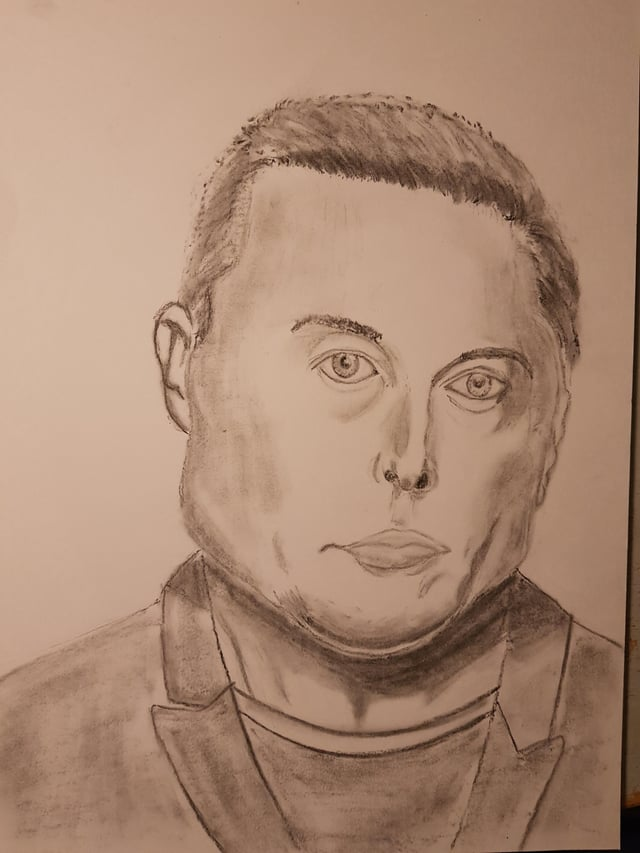

In [355]:
elonURL = requests.get('https://preview.redd.it/twsliey41yk21.jpg?width=640&crop=smart&auto=webp&s=19e34b31877d410d141c019faad30d967caffa16')
elonImg = Image.open(BytesIO(elonURL.content))
elonImg

For the sake of this demo - since this VAE has been designed with 512x512 images in mind, let's square up this image and then compress it into 512x512 resolution.

In [356]:
elonImg=elonImg.crop((0,50,640,690))
elonImg=elonImg.resize((512,512))

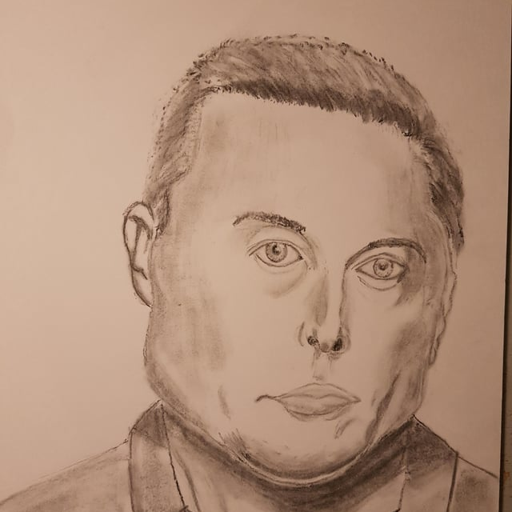

In [357]:
elonImg

As an additional demonstration, we'll resize this image to 64x64 pixels, and then bring it back up again to 512x512. We'll use this as a point of comparison between the VAE decoder and a "traditional" image compression algorithm. We're picking 64x64 because this is the dimension of outputs of the VAE encoder (i.e., this is the "resolution" of the latent space of the VAE encoder-decoder).

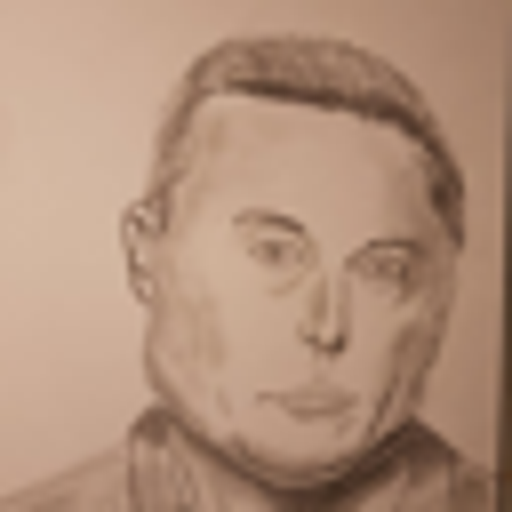

In [358]:
elonImg_compressed=elonImg.resize((64,64))
elonImg_compressed=elonImg_compressed.resize((512,512))
elonImg_compressed

Wow - looks pretty blurry huh. Now let's try compressing him through the VAE.

In [359]:
# Function for turning an image into a VAE input
def img2VAETensor(PILImage):
    PILImage=PILImage.convert('RGB')
    ImgTensor=tfms.ToTensor()(PILImage).unsqueeze(0) * 2.0 - 1.0
    return ImgTensor

# make data the same precision as VAE model precision, and move to same device
elonTensor=img2VAETensor(elonImg).to(torch_device).half()


In [360]:
# VAE encoder function

def VAE_encode(VAETensor):
    init_encode=vae.encode(VAETensor)
    encoded_sample=init_encode.latent_dist.sample()*0.18215
    return encoded_sample
    
# encoding Elon
elonEncodedSample=VAE_encode(elonTensor)

In [361]:
# print out the shape
elonEncodedSample.shape

torch.Size([1, 4, 64, 64])

Looking at the shape of the encoded sample (since it's a VAE, we have to take a sample of a distribution, but I won't go into that) - we can see that there are essentially 4 channels of 64x64 data. While our original image would have been RGB, another common form of image channel data is RGBA, where the A stands for "Alpha". The Alpha channel essentially dictates channel transparency.

So in a sense, we can consider this our "resized" image. 

***A BIG NOTE*** - there is no fixed reason for an image-based Variational AutoEncoder to output an encoded sample into valid image data. This is not a valid, generaliseable assumption to make outside of this cascade of models. Conveniently though, this data actually makes a pretty good, intuitive proxy for a compressed image, so we'll run with it for an easy explanation.

let's look at the compressed image now

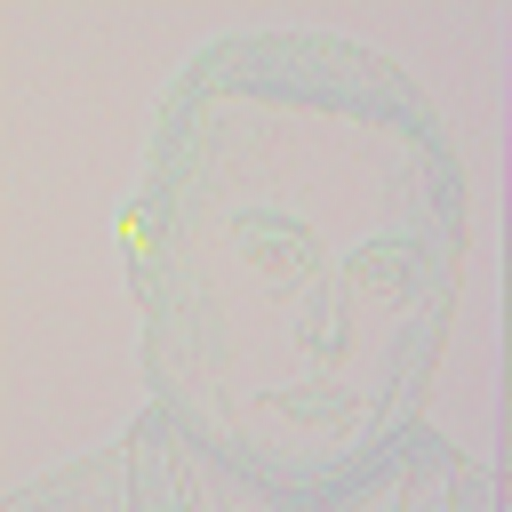

In [362]:
tensor_to_image=tfms.ToPILImage()
elonEncodedSample_normaliseRGBA=(elonEncodedSample+12)/20 #this is sort of arbitrary, forcing these pixels into a 0-1 range
tensor_to_image(elonEncodedSample_normaliseRGBA[0]).resize((512,512))

well look at that - it's all funky looking in the encoded space. But, you can clearly see there's changes in the data that correlate to features in the image itself. There are weird, coloured ridges where the lines in elon's face should be! Strange colour shift, but ignore that for now. It's a bit clearer when we look at each individual channel, so let's do that.

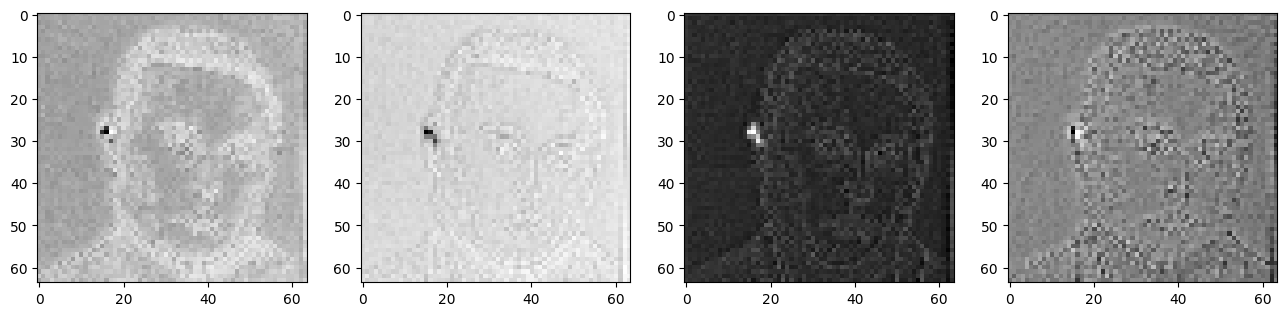

In [363]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(elonEncodedSample[0][c].detach().cpu(), cmap='Greys')

There seems to be a big hotspot at his ear - interesting to note, but not sure why that is! let's decode this image now.

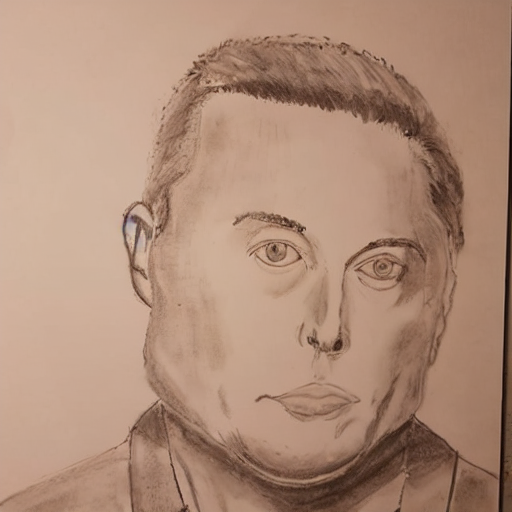

In [364]:
def VAE_decode(VAE_encoded_sample):
    rescaled_sample=(1/0.18215)*VAE_encoded_sample

    with torch.no_grad():
        decodedTensor=vae.decode(rescaled_sample).sample
    decodedTensor=(decodedTensor/2+0.5).clamp(0,1)
    decodedTensor=decodedTensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    decodedTensor=(decodedTensor * 255).round().astype("uint8")
    decodedTensorImg=Image.fromarray(decodedTensor[0])

    return decodedTensorImg

elonDecodedImg_PIL = VAE_decode(elonEncodedSample)
elonDecodedImg_PIL

wow! look at that! This is a super good result after we've compressed the image to 64x64! Let's put all these printouts in a row to compare them. The first image is the original image, the second is the traditionally resized, and the third is the VAE encoded -> decoded image.

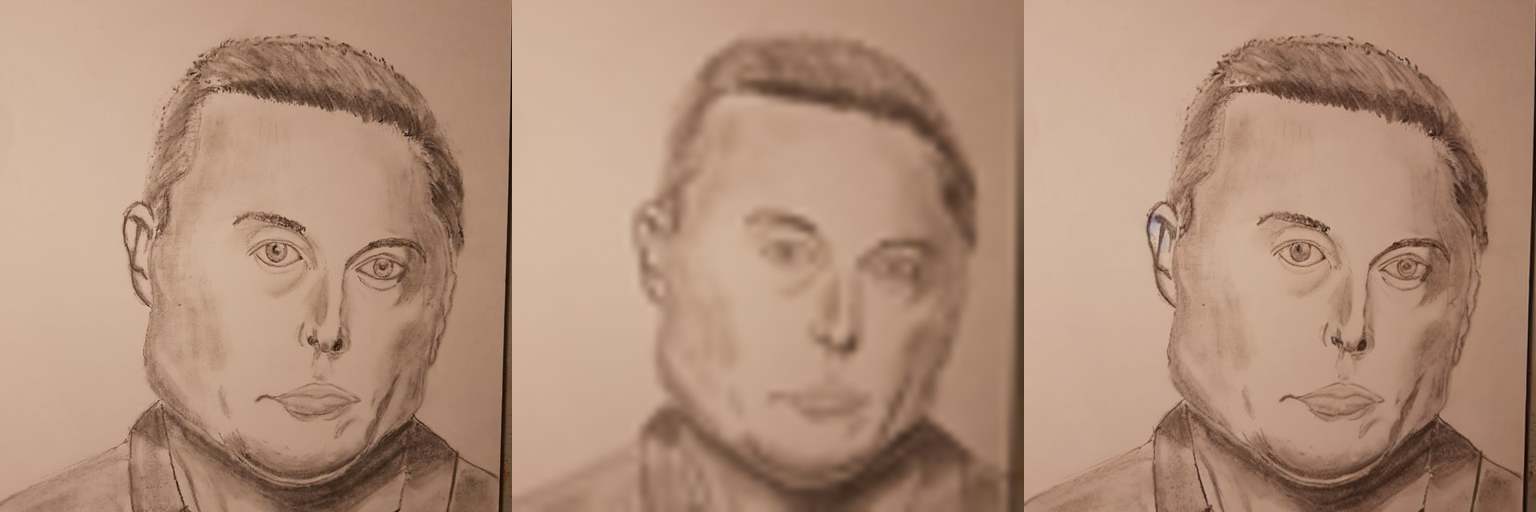

In [365]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid([elonImg, elonImg_compressed, elonDecodedImg_PIL], 1,3)

That's an extremely good result! We can clearly see here that the VAE has done a much better job of compressing the information in the original image compared to a traditional down-res of the image - the VAE output is actually extremely close to the original, despite the fact that we took it down to the same "resolution" as the middle image.

Now why did we go through all that trouble with a VAE? Well, the Denoising algorithm we use in the UNet is extremely computationally expensive when it comes to data throughput (essentially, if you put a big file through, you will potentially blow up your computer). By using a VAE, we can "down-res" the image while preserving a *lot* of the detail in the higher resolution image. This particular VAE encodes pictures to a latent space that is 64x smaller than the original image. By encoding images into this significantly smaller latent space, this makes the denoising UNet a huge amount easier to train/run - and this was the big breakthrough that made latent diffusion possible at higher resolutions in the first place.

Now let's move on to the UNet.

# UNet

This is the final part - our denoising algorithm. Let's load the model first.


In [366]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

unet=unet.to(torch_device).half()

We'll also use a thing called a scheduler. I'll explain how this works a bit later, but for now, just understand that it adds a certain amount of noise at each timestep, and will tell the UNet how much noise to expect. We're going to use this function to add our noise.

In [367]:
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# this is setting the number of theoretical denoising steps we're doing. This number is arbitrary - ignore it for now.
scheduler.set_timesteps(100)

# this is setting the step which we're denoising from - also ignore it for now.
demo_timestep=80

For this demo, let's take our image of elon, add some noise to its latents, and then get our UNet to denoise it.

Let's start by creating a noisy image of Elon through our latents

In [368]:
#creating random noise in the same shape as our latents from earlier
noise = torch.randn_like(elonEncodedSample)

# adding the noise pattern through the scheduler
noisy_elon_latents = scheduler.add_noise(elonEncodedSample, noise, timesteps=torch.tensor([scheduler.timesteps[demo_timestep]]))

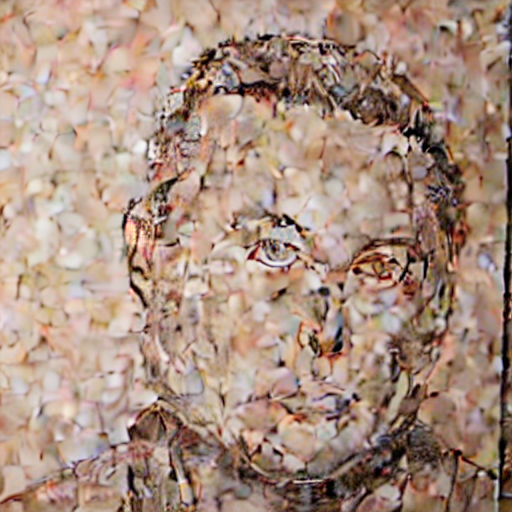

In [369]:
elonDecodedImgNoise=VAE_decode(noisy_elon_latents)
elonDecodedImgNoise

Now we're going to have to create an empty word embedding. This is because our UNet is "conditional", so it needs a text embedding input to be conditioned on. If you pass no words in, it's effectively not "conditioned".

In [370]:
uncond_embeddings=sentence_embedder([''])[0]

We can now start denoising!

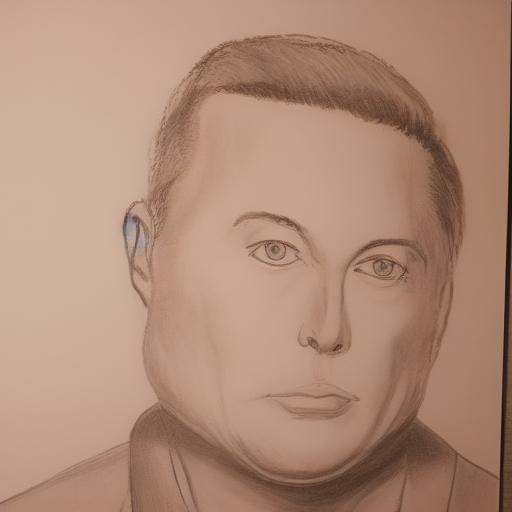

In [371]:
#scale the latents for the unet input
latent_model_input = scheduler.scale_model_input(noisy_elon_latents, scheduler.timesteps[demo_timestep]).half()

# passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
with torch.no_grad():
    noise_pred = unet(latent_model_input, scheduler.timesteps[demo_timestep], encoder_hidden_states=uncond_embeddings).sample

# output the clean latent
clean_latents=scheduler.step(noise_pred, scheduler.timesteps[demo_timestep],noisy_elon_latents).pred_original_sample

elonDecodedImgDenoised_PIL = VAE_decode(clean_latents)
elonDecodedImgDenoised_PIL

Look at that! Now let's compare that to the original picture, and make a note of a few things

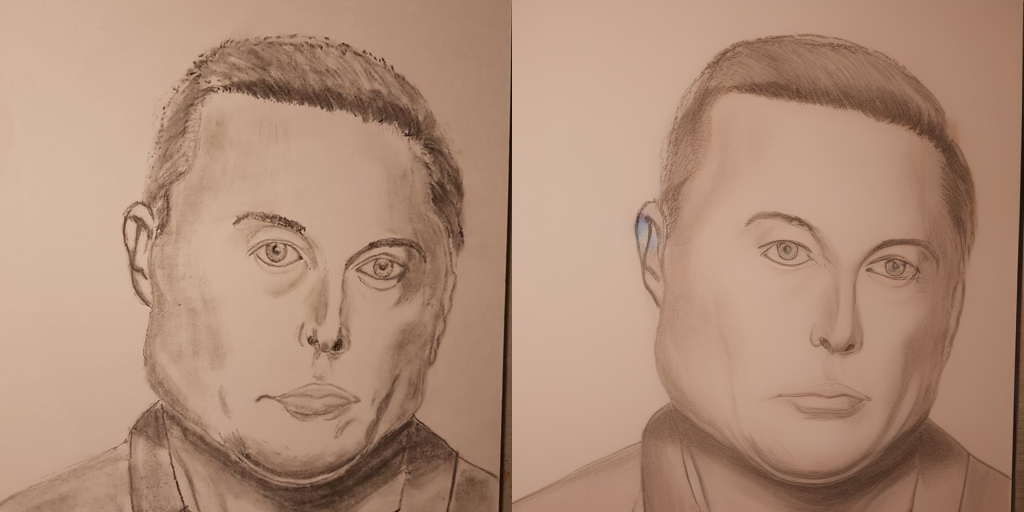

In [372]:
image_grid([elonImg, elonDecodedImgDenoised_PIL], 1, 2)

Our denoised image definitely looks quite clean! However, we can see that the inherent structure of Elon's face is quite different. The broad shapes/shades are there, but the overall structure is sort of more smoothed out, and cleaner. This is where iteratively denoising comes into play - when smaller amounts of noise are injected and removed, higher levels of detail are preserved through the denoising algorithm! Here, try changing the number of scheduler timesteps and demo timestep, and see what that does to the amount of noise that's input into the latents, and the similarity in denoised results of the outputs.

In [373]:


def denoising_explore(num_timesteps, test_timestep):
    test_timestep=test_timestep-1
    scheduler.set_timesteps(num_timesteps)
    noise = torch.randn_like(elonEncodedSample)
    noisy_elon_latents = scheduler.add_noise(elonEncodedSample, noise, timesteps=torch.tensor([scheduler.timesteps[test_timestep]]))
        #scale the latents for the unet input
    latent_model_input = scheduler.scale_model_input(noisy_elon_latents, scheduler.timesteps[test_timestep]).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(latent_model_input, scheduler.timesteps[test_timestep], encoder_hidden_states=uncond_embeddings).sample
    
    # output the clean latent
    clean_latents=scheduler.step(noise_pred, scheduler.timesteps[test_timestep],noisy_elon_latents).pred_original_sample
    
    elonDecodedImgDenoised_PIL = VAE_decode(clean_latents)
    return elonDecodedImgDenoised_PIL


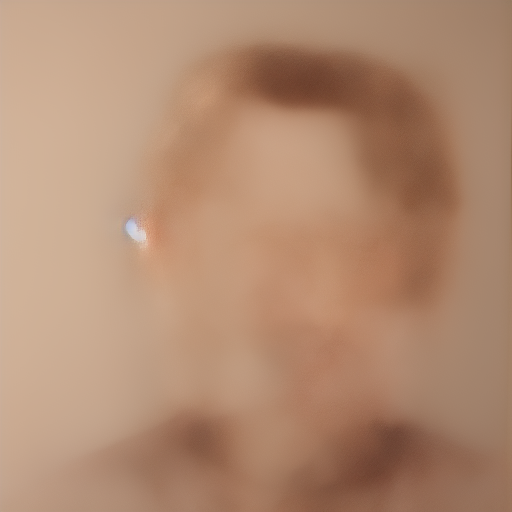

In [374]:
# ITERATE HERE
denoising_explore(num_timesteps=10,
                 test_timestep=4)
    

# Putting it all together

Okay, I've shown you a lot of crap at this point - but how does this all fit together? 

Well, let's imagine we want to create an image from scratch, based on a text prompt. We currently have loaded:
- a model that can turn text into vector embeddings
- a model that can denoise a latent space, and can be guided by vector embeddings
- a model that can turn a latent space into an image

So, what can we do?

Well, if we try denoising an image that is completely noise, what happens?

In [377]:
# define some functions to reuse

def init_noise(random_seed, scheduler):

    latents = torch.randn(
      (1, 4, 64,64),
        generator=torch.manual_seed(random_seed)
    )
    latents = latents.to(torch_device)
    
    latents = latents * scheduler.init_noise_sigma
    return latents

def LDM_noguide_forward(latents, timestep, scheduler=scheduler):
    latents=latents.half()
    latent_model_input = scheduler.scale_model_input(latents, scheduler.timesteps[timestep]).half()
    
    # passing the scaled latent inputs to the unet, with the timestep and the unconditional embeddings
    with torch.no_grad():
        noise_pred = unet(latent_model_input, scheduler.timesteps[timestep], encoder_hidden_states=uncond_embeddings).sample
    
    # output the clean latent
    all_latents=scheduler.step(noise_pred, scheduler.timesteps[timestep], latents)

    return all_latents

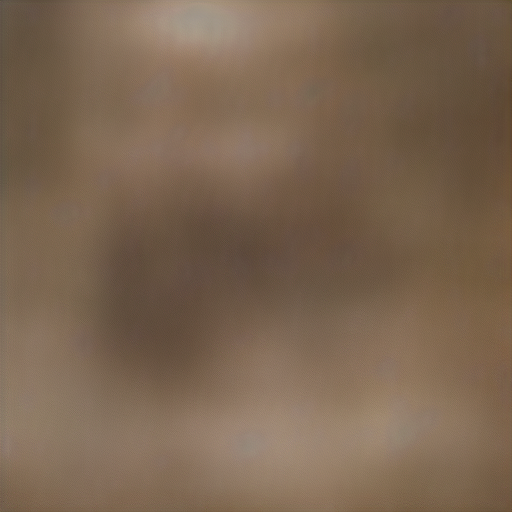

In [378]:
#reinitialise scheduler timesteps
scheduler.set_timesteps(5)

#initialise noise
latents=init_noise(random_seed=9001,
                  scheduler=scheduler)

all_latents=LDM_noguide_forward(latents=latents,
                               timestep=0)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   

denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Weird! when we take completely random noise, denoise it, and then put it through the VAE, you sort of get an extremely blurry looking picture.

Now what happens if we add noise back into the picture, and then denoise it again?

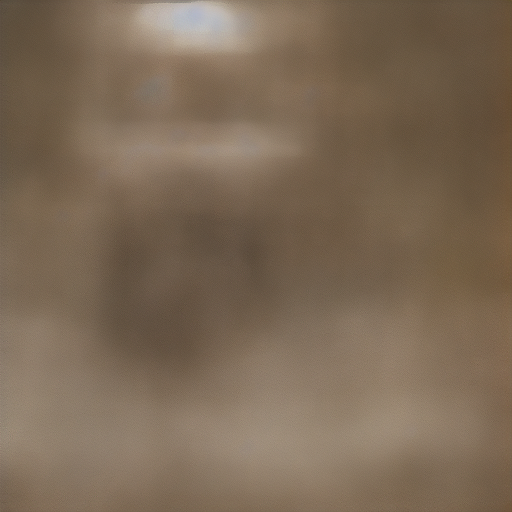

In [379]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=1)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Hmm - slightly more structure... let's do it a few more times


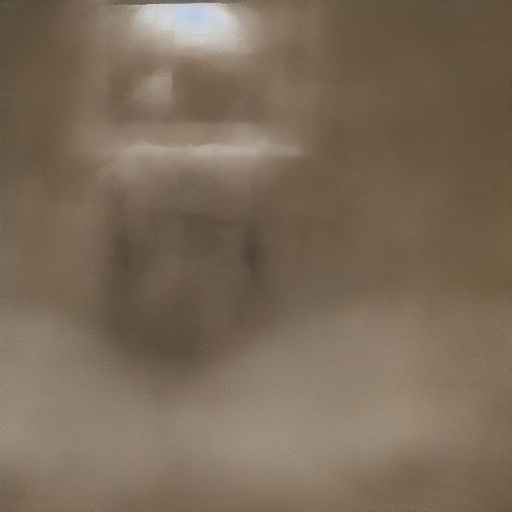

In [380]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=2)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

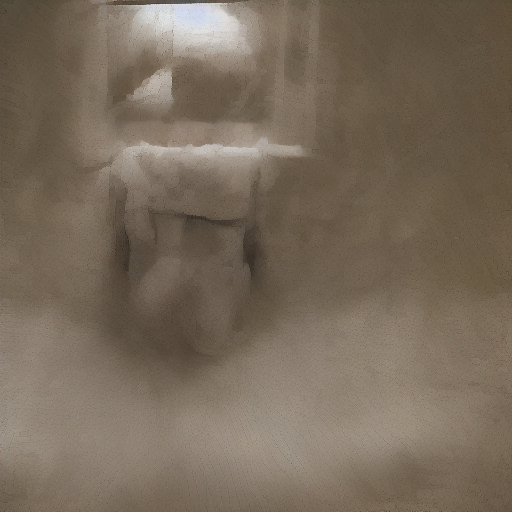

In [381]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=3)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

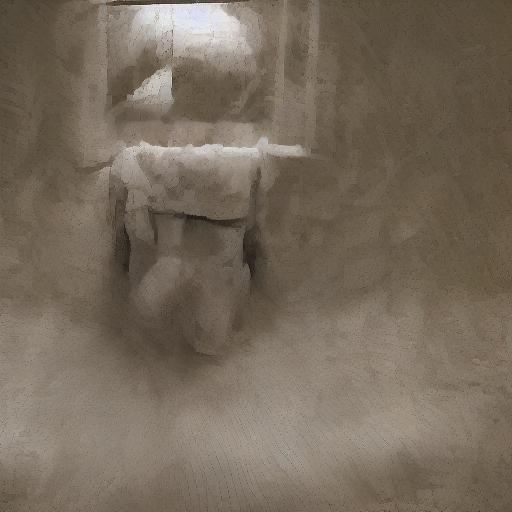

In [382]:
latents=all_latents.prev_sample
all_latents=LDM_noguide_forward(latents=latents,
                               timestep=4)

#output image from VAE decoder
denoised_latents=all_latents.pred_original_sample   
denoisedDecoded=VAE_decode(denoised_latents)
denoisedDecoded

Look at that! That's almost a picture! It sort of looks like a bathroom, with a towel rack, and maybe a mirror? very impressionistic.

What's happening here is that every time the image is denoised, a teeny tiny bit of detail is assumed to exist in the leftover image (even though we know for a fact that the image is completely random garbage). The model is iteratively leaving behind bits of what it "assumes" is correct details of the image. 

You can imagine then, that two particular factors play a great role in determining what the model decides to "leave behind" at each step - the initial structure of the noise, and the number of denoising steps it takes. With the initial noise, there will be particular random features within that noise that the model will "leave behind", and with the number of iterations, think of it as the "step size" of the model being slightly smaller - the size and shape of the noise being added will be different at each step, and therefore the detail being left behind will be inherently smaller, but also different as well. 

I'll wrap the above steps into a neat little function for you to iterate over, with those two particular parameters exposed (i.e. you can change them willy nilly). Play around and see what you find!

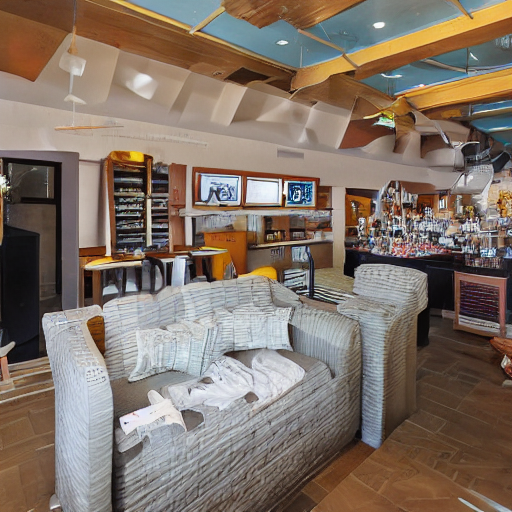

In [215]:
#output image from VAE decoder
elonEncodedSample=(1/0.18215)*latents

with torch.no_grad():
    elonDecodedTensor=vae.decode(elonEncodedSample).sample

elonDecodedImgDenoised=(elonDecodedTensor/2 + 0.5).clamp(0, 1)
elonDecodedImgDenoised = elonDecodedImgDenoised.detach().cpu().permute(0, 2, 3, 1).numpy()
elonDecodedImgDenoised = (elonDecodedImgDenoised * 255).round().astype("uint8")
elonDecodedImgDenoised_PIL = Image.fromarray(elonDecodedImgDenoised[0])
elonDecodedImgDenoised_PIL